# import

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import Bottleneck
import numpy as np
from itertools import product
from math import sqrt
from typing import List
from collections import defaultdict

from data.config import cfg, mask_type
from layers import Detect
from layers.interpolate import InterpolateModule
from backbone import construct_backbone

import torch.backends.cudnn as cudnn
from utils import timer
from utils.functions import MovingAverage, make_net
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import random
%matplotlib inline
import time
from PIL import Image
from torchvision.transforms import ToTensor,ToPILImage
from torchvision.transforms import Resize
from torchvision import transforms
import torch.optim as optim
# from apex.contrib.optimizers import FP16_Optimizer
# from apex.fp16_utils import network_to_half
from torch.optim import lr_scheduler
from torch.autograd import Variable

from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm
from IPython.display import clear_output
def clear():
    clear_output(wait=True)

# 节省显存

In [2]:
save_gpu=True

## 工具类

In [3]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import Bottleneck
import numpy as np
from itertools import product
from math import sqrt
from typing import List
from collections import defaultdict

from data.config import cfg, mask_type
from layers import Detect
from layers.interpolate import InterpolateModule
from backbone import construct_backbone

import torch.backends.cudnn as cudnn
from utils import timer
from utils.functions import MovingAverage, make_net

# This is required for Pytorch 1.0.1 on Windows to initialize Cuda on some driver versions.
# See the bug report here: https://github.com/pytorch/pytorch/issues/17108
torch.cuda.current_device()

# As of March 10, 2019, Pytorch DataParallel still doesn't support JIT Script Modules
use_jit = torch.cuda.device_count() <= 1
if not use_jit:
    print('Multiple GPUs detected! Turning off JIT.')

ScriptModuleWrapper = torch.jit.ScriptModule if use_jit else nn.Module
script_method_wrapper = torch.jit.script_method if use_jit else lambda fn, _rcn=None: fn



class Concat(nn.Module):
    def __init__(self, nets, extra_params):
        super().__init__()

        self.nets = nn.ModuleList(nets)
        self.extra_params = extra_params
    
    def forward(self, x):
        # Concat each along the channel dimension
        return torch.cat([net(x) for net in self.nets], dim=1, **self.extra_params)

prior_cache = defaultdict(lambda: None)

class PredictionModule(nn.Module):
    """
    The (c) prediction module adapted from DSSD:
    https://arxiv.org/pdf/1701.06659.pdf

    Note that this is slightly different to the module in the paper
    because the Bottleneck block actually has a 3x3 convolution in
    the middle instead of a 1x1 convolution. Though, I really can't
    be arsed to implement it myself, and, who knows, this might be
    better.

    Args:
        - in_channels:   The input feature size.
        - out_channels:  The output feature size (must be a multiple of 4).
        - aspect_ratios: A list of lists of priorbox aspect ratios (one list per scale).
        - scales:        A list of priorbox scales relative to this layer's convsize.
                         For instance: If this layer has convouts of size 30x30 for
                                       an image of size 600x600, the 'default' (scale
                                       of 1) for this layer would produce bounding
                                       boxes with an area of 20x20px. If the scale is
                                       .5 on the other hand, this layer would consider
                                       bounding boxes with area 10x10px, etc.
        - parent:        If parent is a PredictionModule, this module will use all the layers
                         from parent instead of from this module.
    """
    
    def __init__(self, in_channels, out_channels=1024, aspect_ratios=[[1]], scales=[1], parent=None, index=0):
        super().__init__()

        self.num_classes = cfg.num_classes
        self.mask_dim    = cfg.mask_dim # Defined by Yolact
        self.num_priors  = sum(len(x)*len(scales) for x in aspect_ratios)
        self.parent      = [parent] # Don't include this in the state dict
        self.index       = index
        self.num_heads   = cfg.num_heads # Defined by Yolact

        if cfg.mask_proto_split_prototypes_by_head and cfg.mask_type == mask_type.lincomb:
            self.mask_dim = self.mask_dim // self.num_heads

        if cfg.mask_proto_prototypes_as_features:
            in_channels += self.mask_dim
        
        if parent is None:
            if cfg.extra_head_net is None:
                out_channels = in_channels
            else:
                self.upfeature, out_channels = make_net(in_channels, cfg.extra_head_net)

            if cfg.use_prediction_module:
                self.block = Bottleneck(out_channels, out_channels // 4)
                self.conv = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=True)
                self.bn = nn.BatchNorm2d(out_channels)

            self.bbox_layer = nn.Conv2d(out_channels, self.num_priors * 4,                **cfg.head_layer_params)
            self.conf_layer = nn.Conv2d(out_channels, self.num_priors * self.num_classes, **cfg.head_layer_params)
            self.mask_layer = nn.Conv2d(out_channels, self.num_priors * self.mask_dim,    **cfg.head_layer_params)
            
            if cfg.use_mask_scoring:
                self.score_layer = nn.Conv2d(out_channels, self.num_priors, **cfg.head_layer_params)

            if cfg.use_instance_coeff:
                self.inst_layer = nn.Conv2d(out_channels, self.num_priors * cfg.num_instance_coeffs, **cfg.head_layer_params)
            
            # What is this ugly lambda doing in the middle of all this clean prediction module code?
            def make_extra(num_layers):
                if num_layers == 0:
                    return lambda x: x
                else:
                    # Looks more complicated than it is. This just creates an array of num_layers alternating conv-relu
                    return nn.Sequential(*sum([[
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                        nn.ReLU(inplace=True)
                    ] for _ in range(num_layers)], []))

            self.bbox_extra, self.conf_extra, self.mask_extra = [make_extra(x) for x in cfg.extra_layers]
            
            if cfg.mask_type == mask_type.lincomb and cfg.mask_proto_coeff_gate:
                self.gate_layer = nn.Conv2d(out_channels, self.num_priors * self.mask_dim, kernel_size=3, padding=1)

        self.aspect_ratios = aspect_ratios
        self.scales = scales

        self.priors = None
        self.last_conv_size = None
        self.last_img_size = None

    def forward(self, x):
        """
        Args:
            - x: The convOut from a layer in the backbone network
                 Size: [batch_size, in_channels, conv_h, conv_w])

        Returns a tuple (bbox_coords, class_confs, mask_output, prior_boxes) with sizes
            - bbox_coords: [batch_size, conv_h*conv_w*num_priors, 4]
            - class_confs: [batch_size, conv_h*conv_w*num_priors, num_classes]
            - mask_output: [batch_size, conv_h*conv_w*num_priors, mask_dim]
            - prior_boxes: [conv_h*conv_w*num_priors, 4]
        """
        # In case we want to use another module's layers
        src = self if self.parent[0] is None else self.parent[0]
        
        conv_h = x.size(2)
        conv_w = x.size(3)
        
        if cfg.extra_head_net is not None:
            x = src.upfeature(x)
        
        if cfg.use_prediction_module:
            # The two branches of PM design (c)
            a = src.block(x)
            
            b = src.conv(x)
            b = src.bn(b)
            b = F.relu(b)
            
            # TODO: Possibly switch this out for a product
            x = a + b

        bbox_x = src.bbox_extra(x)
        conf_x = src.conf_extra(x)
        mask_x = src.mask_extra(x)

        bbox = src.bbox_layer(bbox_x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, 4)
        conf = src.conf_layer(conf_x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, self.num_classes)
        
        if cfg.eval_mask_branch:
            mask = src.mask_layer(mask_x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, self.mask_dim)
        else:
            mask = torch.zeros(x.size(0), bbox.size(1), self.mask_dim, device=bbox.device)

        if cfg.use_mask_scoring:
            score = src.score_layer(x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, 1)

        if cfg.use_instance_coeff:
            inst = src.inst_layer(x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, cfg.num_instance_coeffs)    

        # See box_utils.decode for an explanation of this
        if cfg.use_yolo_regressors:
            bbox[:, :, :2] = torch.sigmoid(bbox[:, :, :2]) - 0.5
            bbox[:, :, 0] /= conv_w
            bbox[:, :, 1] /= conv_h

        if cfg.eval_mask_branch:
            if cfg.mask_type == mask_type.direct:
                mask = torch.sigmoid(mask)
            elif cfg.mask_type == mask_type.lincomb:
                mask = cfg.mask_proto_coeff_activation(mask)

                if cfg.mask_proto_coeff_gate:
                    gate = src.gate_layer(x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, self.mask_dim)
                    mask = mask * torch.sigmoid(gate)

        if cfg.mask_proto_split_prototypes_by_head and cfg.mask_type == mask_type.lincomb:
            mask = F.pad(mask, (self.index * self.mask_dim, (self.num_heads - self.index - 1) * self.mask_dim), mode='constant', value=0)
        
        priors = self.make_priors(conv_h, conv_w, x.device)

        preds = { 'loc': bbox, 'conf': conf, 'mask': mask, 'priors': priors }

        if cfg.use_mask_scoring:
            preds['score'] = score

        if cfg.use_instance_coeff:
            preds['inst'] = inst
        
        return preds

    def make_priors(self, conv_h, conv_w, device):
        """ Note that priors are [x,y,width,height] where (x,y) is the center of the box. """
        global prior_cache
        size = (conv_h, conv_w)

        with timer.env('makepriors'):
            if self.last_img_size != (cfg._tmp_img_w, cfg._tmp_img_h):
                prior_data = []

                # Iteration order is important (it has to sync up with the convout)
                for j, i in product(range(conv_h), range(conv_w)):
                    # +0.5 because priors are in center-size notation
                    x = (i + 0.5) / conv_w
                    y = (j + 0.5) / conv_h
                    
                    for ars in self.aspect_ratios:
                        for scale in self.scales:
                            for ar in ars:
                                if not cfg.backbone.preapply_sqrt:
                                    ar = sqrt(ar)

                                if cfg.backbone.use_pixel_scales:
                                    w = scale * ar / cfg.max_size
                                    h = scale / ar / cfg.max_size
                                else:
                                    w = scale * ar / conv_w
                                    h = scale / ar / conv_h
                                
                                # This is for backward compatability with a bug where I made everything square by accident
                                if cfg.backbone.use_square_anchors:
                                    h = w

                                prior_data += [x, y, w, h]

                self.priors = torch.Tensor(prior_data, device=device).view(-1, 4).detach()
                self.priors.requires_grad = False
                self.last_img_size = (cfg._tmp_img_w, cfg._tmp_img_h)
                self.last_conv_size = (conv_w, conv_h)
                prior_cache[size] = None
            elif self.priors.device != device:
                # This whole weird situation is so that DataParalell doesn't copy the priors each iteration
                if prior_cache[size] is None:
                    prior_cache[size] = {}
                
                if device not in prior_cache[size]:
                    prior_cache[size][device] = self.priors.to(device)

                self.priors = prior_cache[size][device]
        
        return self.priors

class FPN(ScriptModuleWrapper):
    """
    Implements a general version of the FPN introduced in
    https://arxiv.org/pdf/1612.03144.pdf

    Parameters (in cfg.fpn):
        - num_features (int): The number of output features in the fpn layers.
        - interpolation_mode (str): The mode to pass to F.interpolate.
        - num_downsample (int): The number of downsampled layers to add onto the selected layers.
                                These extra layers are downsampled from the last selected layer.

    Args:
        - in_channels (list): For each conv layer you supply in the forward pass,
                              how many features will it have?
    """
    __constants__ = ['interpolation_mode', 'num_downsample', 'use_conv_downsample', 'relu_pred_layers',
                     'lat_layers', 'pred_layers', 'downsample_layers', 'relu_downsample_layers']

    def __init__(self, in_channels):
        super().__init__()

        self.lat_layers  = nn.ModuleList([
            nn.Conv2d(x, cfg.fpn.num_features, kernel_size=1)
            for x in reversed(in_channels)
        ])

        # This is here for backwards compatability
        padding = 1 if cfg.fpn.pad else 0
        self.pred_layers = nn.ModuleList([
            nn.Conv2d(cfg.fpn.num_features, cfg.fpn.num_features, kernel_size=3, padding=padding)
            for _ in in_channels
        ])

        if cfg.fpn.use_conv_downsample:
            self.downsample_layers = nn.ModuleList([
                nn.Conv2d(cfg.fpn.num_features, cfg.fpn.num_features, kernel_size=3, padding=1, stride=2)
                for _ in range(cfg.fpn.num_downsample)
            ])
        
        self.interpolation_mode     = cfg.fpn.interpolation_mode
        self.num_downsample         = cfg.fpn.num_downsample
        self.use_conv_downsample    = cfg.fpn.use_conv_downsample
        self.relu_downsample_layers = cfg.fpn.relu_downsample_layers
        self.relu_pred_layers       = cfg.fpn.relu_pred_layers

    @script_method_wrapper
    def forward(self, convouts:List[torch.Tensor]):
        """
        Args:
            - convouts (list): A list of convouts for the corresponding layers in in_channels.
        Returns:
            - A list of FPN convouts in the same order as x with extra downsample layers if requested.
        """

        out = []
        x = torch.zeros(1, device=convouts[0].device)
        for i in range(len(convouts)):
            out.append(x)

        # For backward compatability, the conv layers are stored in reverse but the input and output is
        # given in the correct order. Thus, use j=-i-1 for the input and output and i for the conv layers.
        j = len(convouts)
        for lat_layer in self.lat_layers:
            j -= 1

            if j < len(convouts) - 1:
                _, _, h, w = convouts[j].size()
                x = F.interpolate(x, size=(h, w), mode=self.interpolation_mode, align_corners=False)
            
            x = x + lat_layer(convouts[j])
            out[j] = x
        
        # This janky second loop is here because TorchScript.
        j = len(convouts)
        for pred_layer in self.pred_layers:
            j -= 1
            out[j] = pred_layer(out[j])

            if self.relu_pred_layers:
                F.relu(out[j], inplace=True)

        cur_idx = len(out)

        # In the original paper, this takes care of P6
        if self.use_conv_downsample:
            for downsample_layer in self.downsample_layers:
                out.append(downsample_layer(out[-1]))
        else:
            for idx in range(self.num_downsample):
                # Note: this is an untested alternative to out.append(out[-1][:, :, ::2, ::2]). Thanks TorchScript.
                out.append(nn.functional.max_pool2d(out[-1], 1, stride=2))

        if self.relu_downsample_layers:
            for idx in range(len(out) - cur_idx):
                out[idx] = F.relu(out[idx + cur_idx], inplace=False)

        return out

class FastMaskIoUNet(ScriptModuleWrapper):

    def __init__(self):
        super().__init__()
        input_channels = 1
        last_layer = [(cfg.num_classes-1, 1, {})]
        self.maskiou_net, _ = make_net(input_channels, cfg.maskiou_net + last_layer, include_last_relu=True)

    def forward(self, x):
        x = self.maskiou_net(x)
        maskiou_p = F.max_pool2d(x, kernel_size=x.size()[2:]).squeeze(-1).squeeze(-1)

        return maskiou_p

## yolact网络

In [4]:
class qmyolact(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = construct_backbone(cfg.backbone)

        if cfg.freeze_bn:
            self.freeze_bn()

        # Compute mask_dim here and add it back to the config. Make sure Yolact's constructor is called early!
        if cfg.mask_type == mask_type.direct:
            cfg.mask_dim = cfg.mask_size ** 2
        elif cfg.mask_type == mask_type.lincomb:
            if cfg.mask_proto_use_grid:
                self.grid = torch.Tensor(np.load(cfg.mask_proto_grid_file))
                self.num_grids = self.grid.size(0)
            else:
                self.num_grids = 0

            self.proto_src = cfg.mask_proto_src

            if self.proto_src is None:
                in_channels = 3
            elif cfg.fpn is not None:
                in_channels = cfg.fpn.num_features
            else:
                in_channels = self.backbone.channels[self.proto_src]
            in_channels += self.num_grids

            # The include_last_relu=false here is because we might want to change it to another function
            self.proto_net, cfg.mask_dim = make_net(in_channels, cfg.mask_proto_net, include_last_relu=False)

            if cfg.mask_proto_bias:
                cfg.mask_dim += 1

        self.selected_layers = cfg.backbone.selected_layers
        src_channels = self.backbone.channels

        if cfg.use_maskiou:
            self.maskiou_net = FastMaskIoUNet()

        if cfg.fpn is not None:
            # Some hacky rewiring to accomodate the FPN
            self.fpn = FPN([src_channels[i] for i in self.selected_layers])
            self.selected_layers = list(range(len(self.selected_layers) + cfg.fpn.num_downsample))
            src_channels = [cfg.fpn.num_features] * len(self.selected_layers)

        self.prediction_layers = nn.ModuleList()
        cfg.num_heads = len(self.selected_layers)

        for idx, layer_idx in enumerate(self.selected_layers):
            # If we're sharing prediction module weights, have every module's parent be the first one
            parent = None
            if cfg.share_prediction_module and idx > 0:
                parent = self.prediction_layers[0]

            pred = PredictionModule(src_channels[layer_idx], src_channels[layer_idx],
                                    aspect_ratios=cfg.backbone.pred_aspect_ratios[idx],
                                    scales=cfg.backbone.pred_scales[idx],
                                    parent=parent,
                                    index=idx)
            self.prediction_layers.append(pred)

        # Extra parameters for the extra losses
        if cfg.use_class_existence_loss:
            # This comes from the smallest layer selected
            # Also note that cfg.num_classes includes background
            self.class_existence_fc = nn.Linear(src_channels[-1], cfg.num_classes - 1)

        if cfg.use_semantic_segmentation_loss:
            self.semantic_seg_conv = nn.Conv2d(src_channels[0], cfg.num_classes - 1, kernel_size=1)

        # For use in evaluation
        self.detect = Detect(cfg.num_classes, bkg_label=0, top_k=cfg.nms_top_k,
                             conf_thresh=cfg.nms_conf_thresh, nms_thresh=cfg.nms_thresh)

    def save_weights(self, path):
        """ Saves the model's weights using compression because the file sizes were getting too big. """
        torch.save(self.state_dict(), path)

    def load_weights(self, path):
        """ Loads weights from a compressed save file. """
        state_dict = torch.load(path)

        # For backward compatability, remove these (the new variable is called layers)
        for key in list(state_dict.keys()):
            if key.startswith('backbone.layer') and not key.startswith('backbone.layers'):
                del state_dict[key]

            # Also for backward compatibility with v1.0 weights, do this check
            if key.startswith('fpn.downsample_layers.'):
                if cfg.fpn is not None and int(key.split('.')[2]) >= cfg.fpn.num_downsample:
                    del state_dict[key]
        self.load_state_dict(state_dict)

    def init_weights(self, backbone_path):
        """ Initialize weights for training. """
        # Initialize the backbone with the pretrained weights.
        self.backbone.init_backbone(backbone_path)

        conv_constants = getattr(nn.Conv2d(1, 1, 1), '__constants__')

        # Quick lambda to test if one list contains the other
        def all_in(x, y):
            for _x in x:
                if _x not in y:
                    return False
            return True

        # Initialize the rest of the conv layers with xavier
        for name, module in self.named_modules():
            # See issue #127 for why we need such a complicated condition if the module is a WeakScriptModuleProxy
            # Broke in 1.3 (see issue #175), WeakScriptModuleProxy was turned into just ScriptModule.
            # Broke in 1.4 (see issue #292), where RecursiveScriptModule is the new star of the show.
            # Note that this might break with future pytorch updates, so let me know if it does
            is_script_conv = False
            if 'Script' in type(module).__name__:
                # 1.4 workaround: now there's an original_name member so just use that
                if hasattr(module, 'original_name'):
                    is_script_conv = 'Conv' in module.original_name
                # 1.3 workaround: check if this has the same constants as a conv module
                else:
                    is_script_conv = (
                            all_in(module.__dict__['_constants_set'], conv_constants)
                            and all_in(conv_constants, module.__dict__['_constants_set']))

            is_conv_layer = isinstance(module, nn.Conv2d) or is_script_conv

            if is_conv_layer and module not in self.backbone.backbone_modules:
                nn.init.xavier_uniform_(module.weight.data)

                if module.bias is not None:
                    if cfg.use_focal_loss and 'conf_layer' in name:
                        if not cfg.use_sigmoid_focal_loss:
                            # Initialize the last layer as in the focal loss paper.
                            # Because we use softmax and not sigmoid, I had to derive an alternate expression
                            # on a notecard. Define pi to be the probability of outputting a foreground detection.
                            # Then let z = sum(exp(x)) - exp(x_0). Finally let c be the number of foreground classes.
                            # Chugging through the math, this gives us
                            #   x_0 = log(z * (1 - pi) / pi)    where 0 is the background class
                            #   x_i = log(z / c)                for all i > 0
                            # For simplicity (and because we have a degree of freedom here), set z = 1. Then we have
                            #   x_0 =  log((1 - pi) / pi)       note: don't split up the log for numerical stability
                            #   x_i = -log(c)                   for all i > 0
                            module.bias.data[0] = np.log((1 - cfg.focal_loss_init_pi) / cfg.focal_loss_init_pi)
                            module.bias.data[1:] = -np.log(module.bias.size(0) - 1)
                        else:
                            module.bias.data[0] = -np.log(cfg.focal_loss_init_pi / (1 - cfg.focal_loss_init_pi))
                            module.bias.data[1:] = -np.log((1 - cfg.focal_loss_init_pi) / cfg.focal_loss_init_pi)
                    else:
                        module.bias.data.zero_()

    def train(self, mode=True):
        super().train(mode)

        if cfg.freeze_bn:
            self.freeze_bn()

    def freeze_bn(self, enable=False):
        """ Adapted from https://discuss.pytorch.org/t/how-to-train-with-frozen-batchnorm/12106/8 """
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                module.train() if enable else module.eval()

                module.weight.requires_grad = enable
                module.bias.requires_grad = enable

    def forward(self, x):
        ###
        couts=None
        fouts=None
        """ The input should be of size [batch_size, 3, img_h, img_w] """
        _, _, img_h, img_w = x.size()
        cfg._tmp_img_h = img_h
        cfg._tmp_img_w = img_w

        with timer.env('backbone'):
            outs = self.backbone(x)
            couts=outs

        # print("backbone outs:")
        # for t in outs:
        #     print("t ",t.shape)

        if cfg.fpn is not None:
            with timer.env('fpn'):
                # Use backbone.selected_layers because we overwrote self.selected_layers
                outs = [outs[i] for i in cfg.backbone.selected_layers]
                outs = self.fpn(outs)
                fouts=outs

        # print("fpn outs:")
        # for t in outs:
        #     print("t ", t.shape)


        proto_out = None
        if cfg.mask_type == mask_type.lincomb and cfg.eval_mask_branch:
            with timer.env('proto'):
                proto_x = x if self.proto_src is None else outs[self.proto_src]

                if self.num_grids > 0:
                    grids = self.grid.repeat(proto_x.size(0), 1, 1, 1)
                    proto_x = torch.cat([proto_x, grids], dim=1)

                proto_out = self.proto_net(proto_x)
                proto_out = cfg.mask_proto_prototype_activation(proto_out)

                if cfg.mask_proto_prototypes_as_features:
                    # Clone here because we don't want to permute this, though idk if contiguous makes this unnecessary
                    proto_downsampled = proto_out.clone()

                    if cfg.mask_proto_prototypes_as_features_no_grad:
                        proto_downsampled = proto_out.detach()

                # Move the features last so the multiplication is easy
                proto_out = proto_out.permute(0, 2, 3, 1).contiguous()

                if cfg.mask_proto_bias:
                    bias_shape = [x for x in proto_out.size()]
                    bias_shape[-1] = 1
                    proto_out = torch.cat([proto_out, torch.ones(*bias_shape)], -1)

        with timer.env('pred_heads'):
            pred_outs = {'loc': [], 'conf': [], 'mask': [], 'priors': []}

            if cfg.use_mask_scoring:
                pred_outs['score'] = []

            if cfg.use_instance_coeff:
                pred_outs['inst'] = []

            for idx, pred_layer in zip(self.selected_layers, self.prediction_layers):
                pred_x = outs[idx]

                if cfg.mask_type == mask_type.lincomb and cfg.mask_proto_prototypes_as_features:
                    # Scale the prototypes down to the current prediction layer's size and add it as inputs
                    proto_downsampled = F.interpolate(proto_downsampled, size=outs[idx].size()[2:], mode='bilinear',
                                                      align_corners=False)
                    pred_x = torch.cat([pred_x, proto_downsampled], dim=1)

                # A hack for the way dataparallel works
                if cfg.share_prediction_module and pred_layer is not self.prediction_layers[0]:
                    pred_layer.parent = [self.prediction_layers[0]]

                p = pred_layer(pred_x)

                for k, v in p.items():
                    pred_outs[k].append(v)

        for k, v in pred_outs.items():
            pred_outs[k] = torch.cat(v, -2)

        if proto_out is not None:
            pred_outs['proto'] = proto_out

        if self.training:
            # For the extra loss functions
            if cfg.use_class_existence_loss:
                pred_outs['classes'] = self.class_existence_fc(outs[-1].mean(dim=(2, 3)))

            if cfg.use_semantic_segmentation_loss:
                pred_outs['segm'] = self.semantic_seg_conv(outs[0])

            return pred_outs
        else:
            if cfg.use_mask_scoring:
                pred_outs['score'] = torch.sigmoid(pred_outs['score'])

            if cfg.use_focal_loss:
                if cfg.use_sigmoid_focal_loss:
                    # Note: even though conf[0] exists, this mode doesn't train it so don't use it
                    pred_outs['conf'] = torch.sigmoid(pred_outs['conf'])
                    if cfg.use_mask_scoring:
                        pred_outs['conf'] *= pred_outs['score']
                elif cfg.use_objectness_score:
                    # See focal_loss_sigmoid in multibox_loss.py for details
                    objectness = torch.sigmoid(pred_outs['conf'][:, :, 0])
                    pred_outs['conf'][:, :, 1:] = objectness[:, :, None] * F.softmax(pred_outs['conf'][:, :, 1:], -1)
                    pred_outs['conf'][:, :, 0] = 1 - objectness
                else:
                    pred_outs['conf'] = F.softmax(pred_outs['conf'], -1)
            else:

                if cfg.use_objectness_score:
                    objectness = torch.sigmoid(pred_outs['conf'][:, :, 0])

                    pred_outs['conf'][:, :, 1:] = (objectness > 0.10)[..., None] \
                                                  * F.softmax(pred_outs['conf'][:, :, 1:], dim=-1)

                else:
                    pred_outs['conf'] = F.softmax(pred_outs['conf'], -1)

            return self.detect(pred_outs, self),couts,fouts

## detecotor

In [5]:
from utils.augmentations import FastBaseTransform
from utils import timer
from utils.functions import SavePath
from layers.output_utils import postprocess
from data import cfg, set_cfg
import threading

def create_random_color():
    # 功能：产生随机RGB颜色
    # 输出：color <class 'tuple'> 颜色

    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)

    color = (r, g, b)

    return color


def draw_mask(img, mask, color):
    # 功能：绘制掩膜
    # 输入：img <class 'numpy.ndarray'> (frame_height, frame_width, 3)
    #      mask <class 'torch.Tensor'> torch.Size([frame_height, frame_width]) 掩膜
    #      color <class 'tuple'> 颜色
    # 输出：img_numpy <class 'numpy.ndarray'> (frame_height, frame_width, 3)

    img_gpu = torch.from_numpy(img).cuda().float()
    img_gpu = img_gpu / 255.0

    # 改变mask的维度 <class 'torch.Tensor'> torch.Size([480, 640, 1])
    mask = mask[:, :, None]

    # color_tensor <class 'torch.Tensor'> torch.Size([3])
    color_tensor = torch.Tensor(color).to(img_gpu.device.index).float() / 255.

    # alpha为透明度，置1则不透明
    alpha = 0.45

    mask_color = mask.repeat(1, 1, 3) * color_tensor * alpha
    inv_alph_mask = mask * (- alpha) + 1
    img_gpu = img_gpu * inv_alph_mask + mask_color

    img_numpy = (img_gpu * 255).byte().cpu().numpy()

    return img_numpy


def draw_segmentation_result(img, mask, classname, score, box, color):
    # 功能：绘制检测结果
    # 输入：img <class 'numpy.ndarray'> (frame_height, frame_width, 3)
    #      mask <class 'torch.Tensor'> torch.Size([frame_height, frame_width]) 掩膜
    #      classname <class 'str'> 类别名称
    #      score <class 'float'> 置信度
    #      box <class 'numpy.ndarray'> (4,) 矩形框坐标
    #      color <class 'tuple'> 颜色
    # 输出：img <class 'numpy.ndarray'> (frame_height, frame_width, 3)

    font_face = cv2.FONT_HERSHEY_DUPLEX
    font_scale = 0.4
    font_thickness = 1

    # 绘制矩形框
    x1, y1, x2, y2 = box[:]
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, font_thickness)

    # 绘制掩膜
    img = draw_mask(img, mask, color)

    # 选取矩形框左上角顶点uv坐标
    u, v = x1, y1
    text_str = '%s: %.2f' % (classname, score)
    text_w, text_h = cv2.getTextSize(text_str, font_face, font_scale, font_thickness)[0]

    # 绘制文字底框
    # 图像，左下角uv坐标，右上角uv坐标，颜色，宽度（-1为填充）
    cv2.rectangle(img, (u, v), (u + text_w, v - text_h - 4), color, -1)

    # 绘制文字
    # 图像，文字内容，左下角uv坐标，字体，大小，颜色，字体宽度
    cv2.putText(img, text_str, (u, v - 3), font_face, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    return img
class YolactDetector():
    def __init__(self, model='./weights/yolact_resnet50_54_800000.pth',id=0):
        # 功能：初始化YolactDetector对象
        # 输入：model <class 'str'> 权重文件的路径

        # CUDA加速模式
        cuda_mode = True
        if cuda_mode:
            cudnn.fastest = True
            torch.set_default_tensor_type('torch.cuda.FloatTensor')
        else:
            torch.set_default_tensor_type('torch.FloatTensor')

        # Yolact参数配置
        # trained_model = cwd[:idx] + '/modules/yolact' + model
        trained_model =model
        pth = SavePath.from_str(trained_model)
        config = pth.model_name + '_config'
        set_cfg(config)

        # 加载网络模型
        print('Loading the model...')
        self.net = qmyolact()
        self.net.load_weights(trained_model)
        self.net.eval()
        if cuda_mode:
            self.net = self.net.cuda()
        self.net.detect.use_fast_nms = True
        self.net.detect.use_cross_class_nms = False
        cfg.mask_proto_debug = False
        self.id=id
        print('  Done.\n')

    def run(self, img, items=['car', 'person'], score_thresholds=[0.2, 0.02], top_ks=[15, 15]):
        # 功能：运行Yolact网络以检测图像中的目标
        # 输入：img <class 'numpy.ndarray'> (frame_height, frame_width, 3)
        #      items <class 'list'> 保留的目标类别
        #      score_thresholds <class 'list'> 与items中的类别对应的置信度阈值
        #      top_ks <class 'list'> 与items中的类别对应的数量阈值
        # 输出：masks <class 'torch.Tensor'>  torch.Size([N, frame_height, frame_width]) N为目标数量
        #      classes <class 'numpy.ndarray'> (N,) N为目标数量
        #      scores <class 'numpy.ndarray'> (N,) N为目标数量
        #      boxes <class 'numpy.ndarray'> (N, 4) N为目标数量

        # 检测图像中的目标
        frame = torch.from_numpy(img).cuda().float()
        batch = FastBaseTransform()(frame.unsqueeze(0))
        preds,couts,fouts = self.net(batch)

        # 建立每个目标的掩膜masks、类别classes、置信度scores、边界框boxes的一一对应关系
        with torch.no_grad():
            h, w, _ = frame.shape

            with timer.env('Postprocess'):
                save = cfg.rescore_bbox
                cfg.rescore_bbox = True
                # 检测结果
                t = postprocess(preds, w, h, visualize_lincomb=False, crop_masks=True,
                                score_threshold=min(score_thresholds))
                cfg.rescore_bbox = save

            with timer.env('Copy'):
                idx = t[1].argsort(0, descending=True)
                masks = t[3][idx]
                ides, scores, boxes = [x[idx].cpu().numpy() for x in t[:3]]

        # classes中存储目标类别的名称
        classes = []
        for i in range(ides.shape[0]):
            name = cfg.dataset.class_names[ides[i]]
            classes.append(name)
        classes = np.array(classes)

        # remain_idxs为保留的检测结果
        remain_idxs = []
        num = len(items)
        num_items = []
        for i in range(num):
            num_items.append(0)

        for i in range(classes.shape[0]):
            if classes[i] in items:
                # 提取目标类别在items中的索引
                idx = items.index(classes[i])

                # 按top_k和score_threshold提取检测结果
                if num_items[idx] < top_ks[idx] and scores[i] > score_thresholds[idx]:
                    remain_idxs.append(i)
                    num_items[idx] += 1

        masks = masks[remain_idxs]
        classes = classes[remain_idxs]
        scores = scores[remain_idxs]
        boxes = boxes[remain_idxs]

        return masks, classes, scores, boxes,couts,fouts

In [6]:
detector = YolactDetector(id=0)

Loading the model...
  Done.



/home/qm/anaconda3/envs/qmtorch/lib/python3.7/site-packages/torch/jit/_recursive.py:182: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/home/qm/anaconda3/envs/qmtorch/lib/python3.7/site-packages/torch/jit/_recursive.py:182: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/home/qm/anaconda3/envs/qmtorch/lib/python3.7/site-packages/torch/jit/_recursive.py:182: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))


### 单线程版本

In [7]:
def get_img_mask_c0(path):
    img = cv2.imread(path)
    masks, classes, scores, boxes,couts,fouts = detector.run(img,score_thresholds=[0.02, 0.02], top_ks=[1, 1])
    if(len(masks)<1):
        print(path,"这个图片无法获取mask_c0")
    mask=masks[0].unsqueeze(0)

    target_c=couts[0].squeeze(0)

    resizec0 = transforms.Resize([138,138])

    maskn=resizec0(mask)


    mask_c0=maskn*target_c
    return mask_c0

## run demo(训练时请不要运行,显存不够） 1.2-2.1

In [8]:
%matplotlib inline
if(save_gpu==False):
    # %matplotlib auto
    # img = cv2.imread('./mp4/empty.png')
    img = cv2.imread('./mp4/market1.jpg')
    t1=time.time()
    # score_thresholds=[0.2, 0.02], top_ks=[15, 14]
    # 第一位是车的置信度，第二位是人的置信度
    # 第一位是检测排名前多少的车，第二位是检测排名前多少的人
    masks, classes, scores, boxes,couts,fouts = detector.run(img,score_thresholds=[0.2, 0.02], top_ks=[15, 1])
    print("masks",masks.shape)
    print("boxes",boxes.shape)
    print("couts0",couts[0].shape)
    print("couts1",couts[1].shape)
    print("fouts0",fouts[0].shape)
    t2=time.time()
    print("time used",t2-t1)

    print('img', type(img), img.shape)
    print('masks', type(masks), masks.shape)
    num=len(scores)
    print('target num',num)
    for i in range(masks.shape[0]):
        mask = masks[i]
        classname = str(classes[i])
        score = float(scores[i])
        box = boxes[i]
        color = create_random_color()
        img = draw_segmentation_result(img, mask, classname, score, box, color)

    # cv2.namedWindow("main", cv2.WINDOW_NORMAL)
    plt.imshow(img)
    plt.show()
    masks=classes=scores=boxe=couts=fouts=0

## 显示结果(训练时请不要运行,显存不够）

In [9]:
def show_onetensor(tensor_img): 
    imgnp=ToPILImage()(tensor_img)
    plt.imshow(imgnp)
    plt.show()
    
if(save_gpu==False):
    t1=time.time()
    tt=get_img_mask_c0('./mp4/market1.jpg')
    t2=time.time()
    print(t2-t1)
    show_onetensor(tt[0])

# 准备数据

## train_batch_size  && version_name

In [10]:
train_batch_size=10
val_batch_size=4
version_name="r50c0_baseline"

## dataset

In [11]:
# train_tfs=transforms.Compose([
#     # 0.1的概率随机旋转
#     transforms.RandomApply([transforms.RandomHorizontalFlip()],p=0.5),
#     transforms.RandomApply([transforms.RandomCrop(138, padding=(14, 14))],p=0.5),
#     transforms.RandomApply([transforms.RandomRotation(20,expand=False)],p=0.5),
#     transforms.RandomApply([transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 2), value=0.6, inplace=False)],p=0.5)
# ]
# )
# val_tfs=None

train_tfs=None
val_tfs=None
class c0_mask_Dataset(Dataset): #继承Dataset
    def __init__(self, root_dir, transform=None): #__init__是初始化该类的一些基础参数
        self.imgs_list =np.load(root_dir)
        self.transform=transform
    
    def __len__(self):#返回整个数据集的大小
        return len(self.imgs_list)
    
    def __getitem__(self,index):#根据索引index返回dataset[index]
        one_c0_masks=get_img_mask_c0(str(self.imgs_list[index][0]))
        if(self.transform!=None):
            one_c0_masks=self.transform(one_c0_masks)
        
        one_type=self.imgs_list[index][1]
        one_type=np.array(one_type)
        one_type=one_type.astype(np.int64)
        one_type=torch.from_numpy(one_type).cuda()
        
        return one_c0_masks, one_type #返回该样本

In [12]:
train_dataset = c0_mask_Dataset("./fusion_train.npy",transform=train_tfs)#初始化类，设置数据集所在路径以及变换
val_dataset = c0_mask_Dataset("./fusion_val.npy",transform=val_tfs)#初始化类，设置数据集所在路径以及变换
# train_dataset = c0_mask_Dataset("./mini_train.npy")#初始化类，设置数据集所在路径以及变换
# val_dataset = c0_mask_Dataset("./mini_val.npy")#初始化类，设置数据集所在路径以及变换
print(train_dataset[0][0].shape,train_dataset[0][1])
print(val_dataset[0][0].shape,val_dataset[0][1])

torch.Size([256, 138, 138]) tensor(0)
torch.Size([256, 138, 138]) tensor(0)


## dataloader

In [13]:
train_dataloader = DataLoader(train_dataset,batch_size=train_batch_size,shuffle=True)#使用DataLoader加载数据
val_dataloader = DataLoader(val_dataset,batch_size=val_batch_size,shuffle=True)#使用DataLoader加载数据

# for i_batch,batch_data in enumerate(dataloader):
#     print(i_batch)#打印batch编号
#     print(batch_data[0].shape)#打印该batch里面图片的大小
#     print(batch_data[1])#打印该batch里面图片的标签

## 看看数据(训练时请不要运行,显存不够）

In [14]:
def show_onetensor(tensor_img): 
    imgnp=ToPILImage()(tensor_img)
    plt.imshow(imgnp)
    plt.show()
def show_batchtesnor(tensor_img,line=3):
    imgnp_list=[]
    for i in tensor_img:
        imgnp_list.append(ToPILImage()(i))
        
    num=len(imgnp_list)
    print('num=',num)
    if(num>1):
        row=num//line
        print('row=',row)
        fig,axes=plt.subplots(row+1,line)
        plt.rcParams['figure.figsize'] = (12.0, 8.0) # 单位是inches
        for i in range(0,num):
            axi=axes[i//line,i%line]
            axi.imshow(imgnp_list[i])
        plt.show()

### train(训练时请不要运行,显存不够） 8GB显存

In [15]:
if(save_gpu==False):
    num=1
    flag=0

    label=None
    for a,b in enumerate(train_dataloader):
        print(b[0].shape)
        label=b[1]
        print(label)
    #     show_onetensor(b[0][0])
        # show_batchtesnor(b[0],batch_size)
        flag=flag+1
        if(flag==num):
            break
        a.detach()
        b.detach()
    print(b[1].dtype)

### val(训练时请不要运行,显存不够）

In [16]:
if(save_gpu==False):
    num=1
    flag=0

    label=None
    for a,b in enumerate(val_dataloader):
        print(b[0].shape)
        label=b[1]
        print(label)
    #     show_onetensor(b[0][0])
        # show_batchtesnor(b[0],batch_size)
        flag=flag+1
        if(flag==num):
            break
    print(b[1].dtype)

# 模型

In [17]:
resnet50=torchvision.models.resnet50(pretrained=True)
class r50c0(nn.Module):
    def __init__(self,num_class):
        super().__init__()
        self.backbone=nn.Sequential(*list(resnet50.children())[5:9])
        self.fc=nn.Sequential(
            nn.Linear(2048,num_class)
        )
    def forward(self, x):
        x=self.backbone(x)
        x=x.view(-1,2048)
        x=self.fc(x)
        return x
model=r50c0(993).cuda()

### (训练时请不要运行,显存不够）

In [18]:
if(save_gpu==False):
    x=torch.randn([1,256,138,138]).cuda()
    y=model(x)
    print(y.shape)

# 开始训练

## 参数

In [19]:
#交叉熵代价函数
criterion = nn.CrossEntropyLoss()
#
optimizer = optim.SGD(model.parameters(), lr = 0.01, weight_decay=5e-4, momentum=0.9, nesterov=True)
#
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


## 损失记录

In [20]:
train_epoch_loss=[]
train_epoch_acc=[]
val_epoch_loss=[]
val_epoch_acc=[]


last_val_acc=-1
last_val_acc_name=-1

## 训练函数

In [21]:
def train_model(train_dataloader, val_dataloader,mycriterion, myoptimizer, myscheduler, my_num_epochs=50):
    global last_val_acc,last_val_acc_name,train_epoch_loss,train_epoch_acc,val_epoch_loss,val_epoch_acc
    since_time = time.time()

    for epoch_i in range(0,my_num_epochs):
        print(myoptimizer.state_dict()['param_groups'][0]['lr'])
        epoch_start_time=time.time()
        # Each epoch has a training and validation phase
        # myscheduler.step()
        ############################################################################train
        ############################################################################train
        ############################################################################train
        # Set model to training mode
        model.train(True)  
        running_loss = 0.0
        running_corrects_num = 0.0
        # Iterate over data.
        pbar1 = tqdm(total=len(train_dataloader),desc="epoch:"+str(epoch_i)+':train',leave=False,ncols=130,position=0)
        for data in train_dataloader:
            tb_start=time.time()
            # get the inputs
            inputs, labels = data
            now_batch_size, c, h, w = inputs.shape
            if now_batch_size < train_batch_size:  # skip the last batch
#                 print('continue')
                continue
            inputs = Variable(inputs.cuda().detach())
            labels = Variable(labels.cuda().detach())
            # print(inputs.shape)
            # print(labels.shape)
            
            # zero the parameter gradients
            myoptimizer.zero_grad()

            # forward
            outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            # print(outputs.shape)
            # print(preds.shape)
            loss = mycriterion(outputs, labels)


            # statistics
            running_loss += loss.item()
            running_corrects_num += float(torch.sum(preds == labels.data))
            
            # backward + optimize only if in training phase
            loss.backward()
            myoptimizer.step()
            
            tb_end=time.time()
            pbar1.set_postfix(batch_time=tb_end-tb_start,train_epoch_time=tb_end-epoch_start_time)
            pbar1.update(1)
        pbar1.close()
        epoch_train_end_time=time.time()
            
        myscheduler.step()
        ##############
        #train_loss
        train_loss=running_loss
        train_epoch_loss.append(train_loss)
        #train_acc
        train_data_set_len=len(train_dataset.imgs_list)
        train_acc=running_corrects_num/train_data_set_len
        train_epoch_acc.append(train_acc)
        
        ############################################################################val
        ############################################################################val
        ############################################################################val
        # Set model to training mode
        model.train(False)  
        running_loss = 0.0
        running_corrects_num = 0.0
        # Iterate over data.
        pbar2 = tqdm(total=len(val_dataloader),desc="epoch:"+str(epoch_i)+':val',leave=False,ncols=130,position=0)
        for data in val_dataloader:
            # get the inputs
            tb_start=time.time()
            inputs, labels = data
            now_batch_size, c, h, w = inputs.shape
            if now_batch_size < val_batch_size:  # skip the last batch
#                 print('continue')
                continue
            inputs = Variable(inputs.cuda().detach())
            labels = Variable(labels.cuda().detach())
            # print(inputs.shape)
            # print(labels.shape)
            
            # zero the parameter gradients
            myoptimizer.zero_grad()
            
            with torch.no_grad():
                outputs = model(inputs)

            # forward
            outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            # print(outputs.shape)
            # print(preds.shape)
            loss = mycriterion(outputs, labels)


            # statistics
            running_loss += loss.item()
            running_corrects_num += float(torch.sum(preds == labels.data))
            
            tb_end=time.time()
            pbar2.set_postfix(batch_time=tb_end-tb_start,val_epoch_time=tb_end-epoch_train_end_time)
            pbar2.update(1)
        pbar2.close()
        
        ##############
        #val_loss
        val_loss=running_loss
        val_epoch_loss.append(val_loss)
        # val_acc
        val_data_set_len=len(val_dataset.imgs_list)
        val_acc=running_corrects_num/val_data_set_len
        val_epoch_acc.append(val_acc)
        ########################################################保存最好的val_acc模型
        ########################################################保存最好的val_acc模型
        ########################################################保存最好的val_acc模型
        
        if(last_val_acc==-1):
            last_val_acc=val_acc
        else:
            if(val_acc>last_val_acc):
                save_name="./"+version_name+"_acc_"+str(val_acc)[:4]+".pth"
                torch.save(model,save_name)
                if(last_val_acc_name!=-1):
                    try:
                        os.remove(last_val_acc_name)
                    except:
                        pass
                last_val_acc=val_acc
                last_val_acc_name=save_name
        ######################################################绘制acc图片
        ######################################################绘制acc图片
        ######################################################绘制acc图片
        clear()
        print("one epoch minutes:",(time.time()-epoch_start_time)/60)
        print("epoch i=",epoch_i)
        print('train_loss:',train_loss)
        print('train_acc:',train_acc)
        print('val_loss:',val_loss)
        print('val_acc:',val_acc)
        fig,axes=plt.subplots(2,2)
        plt.rcParams['figure.figsize'] = (12.0, 12.0) # 单位是inches
        axes[0,0].set_title('train_loss')
        axes[0,0].plot(train_epoch_loss,marker='o')
        axes[0,1].set_title('train_ACC')
        axes[0,1].plot(train_epoch_acc,marker='o')
        axes[1,0].set_title('val_loss')
        axes[1,0].plot(val_epoch_loss,marker='o')
        axes[1,1].set_title('val_ACC')
        axes[1,1].plot(val_epoch_acc,marker='o')
        plt.show()
    print("total minutes:",(time.time()-since_time)/60)
    ######################################################保存acc数据
    train_log=[]
    train_log.append(train_epoch_loss)
    train_log.append(train_epoch_acc)
    train_log.append(val_epoch_loss)
    train_log.append(val_epoch_acc)
    np.save("./"+version_name+".npy",train_log)

## 开始训练

one epoch minutes: 19.15667362610499
epoch i= 19
train_loss: 1426.7314524557441
train_acc: 0.8695818948983506
val_loss: 1367.9337996151298
val_acc: 0.6432527693856999


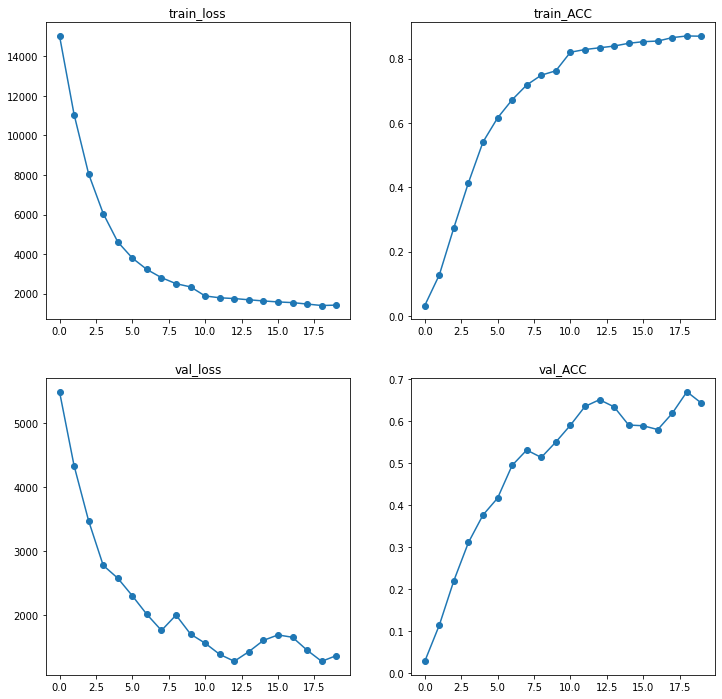

total minutes: 382.7219458937645


In [22]:
train_model(train_dataloader,val_dataloader,criterion,optimizer,exp_lr_scheduler,20)

one epoch minutes: 19.19856199423472
epoch i= 19
train_loss: 750.7263817358762
train_acc: 0.9474875335634829
val_loss: 1223.286257813219
val_acc: 0.6910876132930514


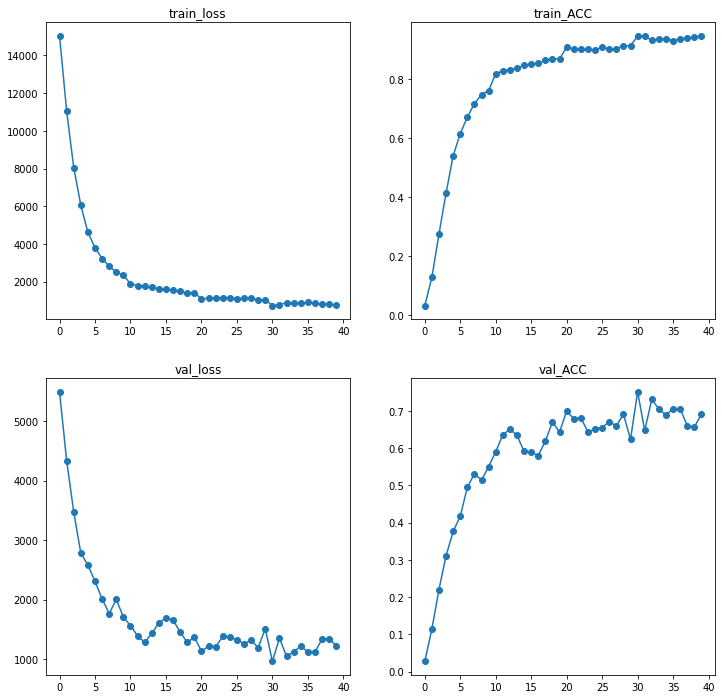

total minutes: 383.12068083683647


In [23]:
train_model(train_dataloader,val_dataloader,criterion,optimizer,exp_lr_scheduler,20)

one epoch minutes: 19.486686368783314
epoch i= 19
train_loss: 580.1194578455761
train_acc: 0.9672803989259685
val_loss: 1002.9144578357227
val_acc: 0.75


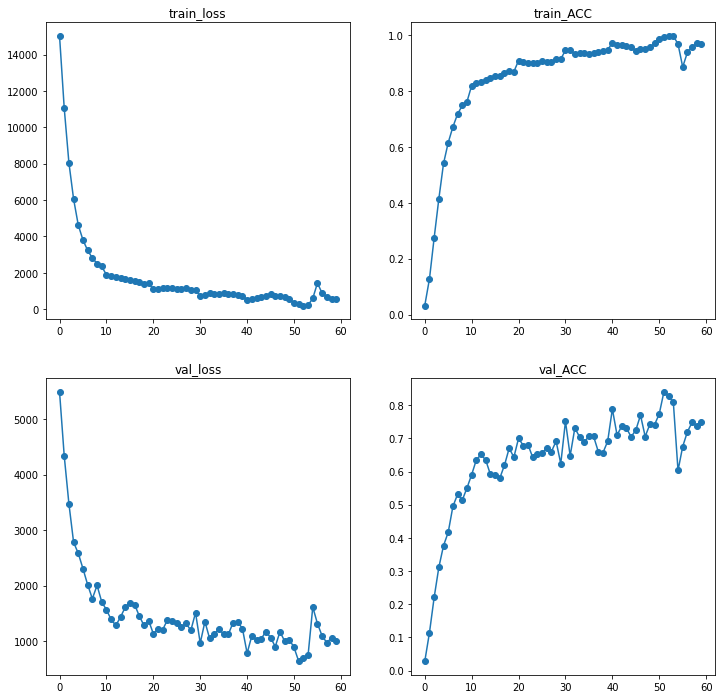

total minutes: 383.9897414882978


In [25]:
train_model(train_dataloader,val_dataloader,criterion,optimizer,exp_lr_scheduler,20)

## 加载训练参数模型

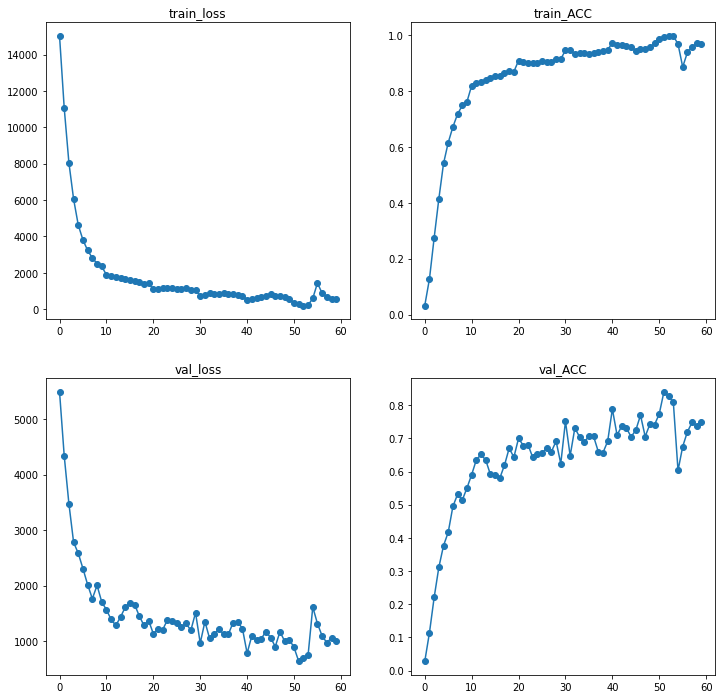

In [27]:
log=np.load("./"+version_name+".npy")
fig,axes=plt.subplots(2,2)
plt.rcParams['figure.figsize'] = (12.0, 12.0) # 单位是inches
axes[0,0].set_title('train_loss')
axes[0,0].plot(log[0],marker='o')
axes[0,1].set_title('train_ACC')
axes[0,1].plot(log[1],marker='o')
axes[1,0].set_title('val_loss')
axes[1,0].plot(log[2],marker='o')
axes[1,1].set_title('val_ACC')
axes[1,1].plot(log[3],marker='o')
plt.show()

In [28]:
print(log[3])
print(max(log[3]))

[0.02769386 0.11404834 0.22029204 0.31117825 0.37663646 0.41691843
 0.49496475 0.53147029 0.51384693 0.55060423 0.59063444 0.63544814
 0.65156093 0.63444109 0.59113797 0.58937563 0.58031219 0.61933535
 0.6704431  0.64325277 0.70040282 0.6784995  0.68152064 0.64350453
 0.65206445 0.65533736 0.67094663 0.65986908 0.69159114 0.62386707
 0.75151057 0.64753273 0.73111782 0.70493454 0.68907351 0.70644512
 0.70594159 0.66012085 0.6570997  0.69108761 0.78851964 0.71022155
 0.7366566  0.73086606 0.70493454 0.72482377 0.76988922 0.70568983
 0.74269889 0.74118832 0.77416918 0.84063444 0.82703927 0.80916415
 0.60322256 0.67547835 0.71978852 0.74848943 0.73791541 0.75      ]
0.8406344410876133
